# WGCNA Analysis of Genes

**Created**: 14 October 2021

## Environment

In [18]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: patchwork

also installing the dependencies ‘credentials’, ‘zip’, ‘gitcreds’, ‘ini’, ‘gert’, ‘gh’, ‘whisker’, ‘xopen’, ‘brew’, ‘commonmark’, ‘usethis’, ‘pkgbuild’, ‘rcmdcheck’, ‘remotes’, ‘roxygen2’, ‘rversions’, ‘sessioninfo’






✔  checking for file ‘/tmp/RtmpZirB9u/remotes8bdb72d42053/thomasp85-patchwork-79223d3/DESCRIPTION’
─  preparing ‘patchwork’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘patchwork_1.1.0.9000.tar.gz’
   


In [22]:
library(WGCNA)
library(tidyverse)
library(RColorBrewer)
library(patchwork)

options(stringsAsFactors = FALSE)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

## Load Data

In [2]:
gene.exp <- read.table("/nfs/team282/data/gains_team282/Logcpm_864_20416.txt")
gene.info <- read.table("/nfs/team282/data/gains_team282/Gene_info_864_20416.txt")
sample.info <- read.table("/nfs/team282/data/gains_team282/Sample_info_864.txt")
sample.key <- read.table("/nfs/team282/data/gains_team282/Sample_key.txt", header=T)

gene.exp <- as.data.frame(t(gene.exp))

In [3]:
head(gene.exp)

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,⋯,ENSG00000288253,ENSG00000288302,ENSG00000288349,ENSG00000288393,ENSG00000288398,ENSG00000288538,ENSG00000288559,ENSG00000288562,ENSG00000288573,ENSG00000288582
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UK02270173_3,0.34012821,4.898920,4.465997,1.822869,9.581159,1.3758538,4.186578,3.488499,5.805762,1.0618773,⋯,0.5211096,1.2928966,0.5211096,0.92165487,1.127188,1.1271881,0.9399463,0.86534652,0.3123157,2.801152
UK15130120_3,0.06630101,4.706715,3.924020,1.478760,10.095049,1.7447793,4.663194,3.231836,4.363694,1.3247639,⋯,0.5091977,1.7346214,0.4851631,0.06630101,1.852036,0.6455584,0.9210902,0.06630101,0.2198352,3.332929
UK58000006_3,0.21554396,4.809392,4.470798,2.311528,10.141189,0.8001246,4.677520,3.731074,5.832399,1.2544840,⋯,0.2934862,1.5206702,0.6302951,0.66002490,1.311795,1.4712176,1.0224079,0.29348619,0.1331492,4.004558
UK47010004_3,0.10881599,4.691238,4.382662,1.933702,10.962529,1.6210960,4.028219,3.064233,5.396777,1.2454960,⋯,0.3045445,0.9561419,1.0948926,0.30454451,1.146860,1.8421000,0.7698445,0.25804514,0.1088160,2.616230
UK42020088_5,0.22147316,4.748680,4.353763,1.908556,10.818277,0.7343902,4.134153,3.070422,5.287726,0.7908250,⋯,0.0927073,1.2187119,0.6756576,0.13691861,1.089688,2.0654798,0.8182356,0.04709819,0.2214732,2.436579
UK47490007_3,0.32285107,4.811800,4.287130,1.404965,10.444919,1.9102720,4.045597,2.944848,5.198537,0.7490989,⋯,0.5159574,2.0290134,1.2176383,0.36359557,1.239695,0.7795298,0.6205193,1.05301187,0.0998434,3.862273


In [4]:
dim(gene.exp)

[1]   864 20416

In [5]:
head(gene.info)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,protein_id,protein_version,ccds_id
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1248375,X,100627108,100639991,12884,-,ensembl_havana,gene,NA,NA,ENSG00000000003,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2612838,20,50934867,50958555,23689,-,ensembl_havana,gene,NA,NA,ENSG00000000419,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
198068,1,169849631,169894267,44637,-,ensembl_havana,gene,NA,NA,ENSG00000000457,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
197489,1,169662007,169854080,192074,+,ensembl_havana,gene,NA,NA,ENSG00000000460,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
46865,1,27612064,27635185,23122,-,ensembl_havana,gene,NA,NA,ENSG00000000938,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
213754,1,196652043,196747504,95462,+,ensembl_havana,gene,NA,NA,ENSG00000000971,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [6]:
dim(gene.info)

[1] 20416    27

In [7]:
head(sample.info)

,manual_qc,id_study_lims,name,description,sanger_sample_id,supplier_name,last_updated,id_library_lims,id_pool_lims,id_iseq_flowcell_tmp,⋯,TIN.mean.,TIN.median.,TIN.stdev.,Concentration,num_samples_per_lane,SRSUnsup,globin_rate_fromcounts,PCOutlier,OtherOutlier,GAinSID
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<lgl>,<lgl>,<chr>
gains8032857,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032857,UK02270173_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930558,⋯,69.51307,76.82800,23.72743,116.731,77,2,0.6790401,FALSE,FALSE,UK02270173
gains8032858,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032858,UK15130120_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930559,⋯,65.03706,71.49895,24.13243,76.185,77,2,0.6826886,FALSE,FALSE,UK15130120
gains8032859,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032859,UK58000006_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930560,⋯,70.85535,78.07773,23.24183,59.767,77,2,1.4290063,FALSE,FALSE,UK58000006
gains8032860,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032860,UK47010004_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930561,⋯,68.16224,75.05450,23.56361,105.000,77,1,0.9177558,FALSE,FALSE,UK47010004
gains8032861,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032861,UK42020088_5,2019-09-30 21:01:38,DN548016D,NT1557159B,6930562,⋯,64.67378,72.53810,26.03766,87.843,77,1,0.4031685,FALSE,FALSE,UK42020088
gains8032862,1,5890,HG_The Genomic Advances in Sepsis (GAinS) RNA-seq,Total leukocyte RNA,gains8032862,UK47490007_3,2019-09-30 21:01:38,DN548016D,NT1557159B,6930563,⋯,62.79935,68.60305,24.27960,67.484,77,2,1.1993500,FALSE,FALSE,UK47490007


In [8]:
dim(sample.info)

[1] 864  46

In [9]:
head(sample.key)

,SangerSampleID,GAinSID
,<chr>,<chr>
1,gains8032857,UK02270173_3
2,gains8032858,UK15130120_3
3,gains8032859,UK58000006_3
4,gains8032860,UK47010004_3
5,gains8032861,UK42020088_5
6,gains8032862,UK47490007_3


In [10]:
dim(sample.key)

[1] 864   2

## WGCNA Checks

The following function identifies genes with excessive missing values and outlier samples. It is generally more important for microarray data.

In [11]:
gsg <- goodSamplesGenes(gene.exp)
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

## Soft Threshold

The adjacency matrix generated using the correlation function does not fit a scale-free topology. A scaling function is used to generate the appropriate gene degree distribution. A parameter of this scaling function, $\beta$, is estimated by trying multiple values and checking how well the resulting network fits the assumptions of a scale-free network. Here, I try all integer values in $[1,20]$.

In [12]:
powers = seq(1, 20, by=1)

soft.thresholds = pickSoftThreshold(gene.exp, powerVector=powers, networkType="unsigned", corFnc=bicor)

soft.threshold = soft.thresholds$powerEstimate

Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "

   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.186  0.630          0.904 3830.00  3.79e+03 7030.0
2      2    0.482 -0.768          0.839 1240.00  1.07e+03 3480.0
3      3    0.708 -1.170          0.884  526.00  3.72e+02 2070.0
4      4    0.758 -1.350          0.911  264.00  1.57e+02 1370.0
5      5    0.791 -1.460          0.937  148.00  7.01e+01  976.0
6      6    0.794 -1.550          0.945   90.00  3.41e+01  728.0
7      7    0.810 -1.590          0.958   58.00  1.75e+01  561.0
8      8    0.823 -1.610          0.969   39.20  9.26e+00  443.0
9      9    0.826 -1.630          0.973   27.50  5.11e+00  356.0
10    10    0.828 -1.650          0.974   19.90  2.88e+00  291.0
11    11    0.815 -1.670          0.965   14.80  1.66e+00  241.0
12    12    0.821 -1.640          0.966   11.20  9.81e-01  201.0
13    13    0.826 -1.620          0.961    8.68  5.84e-01  169.0
14    14    0.829 -1.590          0.952    6.84  3.58e-01  144.0
15    15    0.838 -1.540 

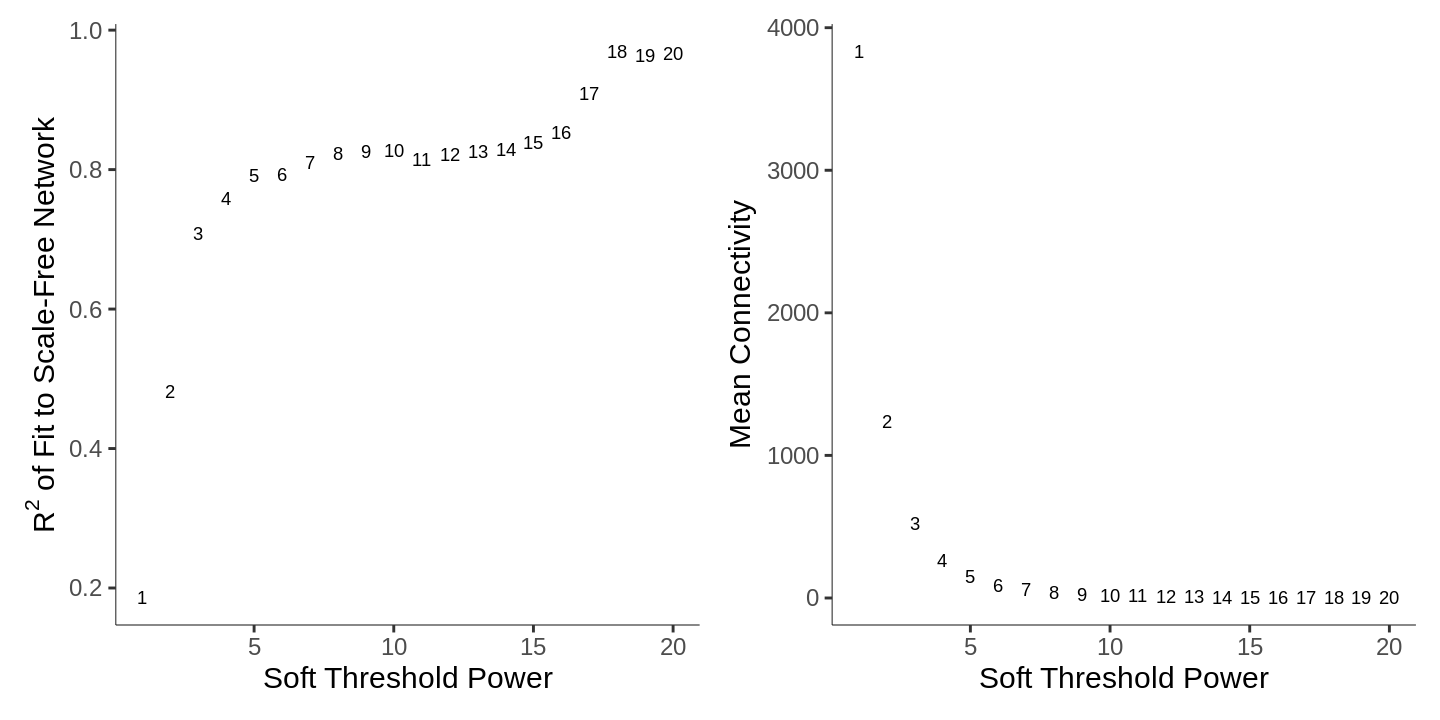

In [38]:
options(repr.plot.width=12, repr.plot.height=6)

p1 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=SFT.R.sq, label=Power)) +
    xlab("Soft Threshold Power") + ylab(bquote(R^2*" of Fit to Scale-Free Network")) +
    ggplot_theme

p2 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=mean.k., label=Power)) +
    xlab("Soft Threshold Power") + ylab("Mean Connectivity") +
    ggplot_theme

p1 + p2

In [13]:
print(soft.threshold)

[1] 16


## Adjacency and TOM Matrices

The adjacency matrix defines the similarity between all genes in the sample data. I am using the [biweight midcorrelation](https://en.wikipedia.org/wiki/Biweight_midcorrelation) (`bicor`) function to estimate similarity. It is a median-based approach that is less sensitive to outliers.

I use $\beta=16$ for the scaling function, which was determined in the previous step. Then, the topological overlap metric (TOM) matrix is generated from the adjacency matrix. For details, check the original WGCNA paper.

In [39]:
adjacency.matrix = adjacency(gene.exp, type="unsigned", corFnc=bicor, corOptions=list(use="pairwise.complete.obs", pearsonFallback="none"), power=soft.threshold)

TOM.matrix = TOMsimilarity(adjacency.matrix)

dir.create("~/gains_team282/nikhil/expression/gene_expression/", recursive=TRUE)
saveRDS(TOM.matrix, file="~/gains_team282/nikhil/expression/gene_expression/TOM.matrix.RDS")

TOM.dist = 1 - TOM.matrix

Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Some results will be NA.”


..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


Warning message in dir.create("~/gains_team282/nikhil/expression/gene_expression/", :
“'/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression' already exists”


## Clustering TOM Matrix

The gene co-expression modules are generated by clustering the TOM matrix.

In [40]:
dendrogram = hclust(as.dist(TOM.dist), method="average")

svg(filename="04_Expression/results/gene_expression_dendrogram.svg", width=8, height=5)
plot(dendrogram, labels=FALSE, main="Gene Expression TOM Dendrogram")
dev.off()

dynamic.mods = cutreeDynamic(
  dendro=dendrogram, distM=TOM.dist, pamRespectsDendro=FALSE,
  minClusterSize = 10
)
rm(TOM.dist)

png 
  2

 ..cutHeight not given, setting it to 0.999  ===>  99% of the (truncated) height range in dendro.
 ..done.


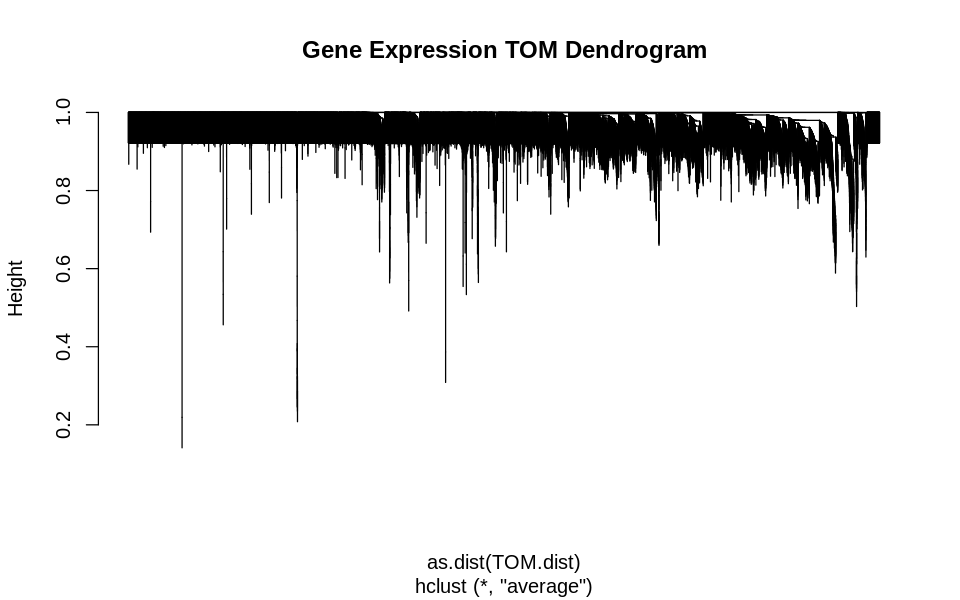

In [42]:
options(repr.plot.width=8, repr.plot.height=5)

plot(dendrogram, labels=FALSE, main="Gene Expression TOM Dendrogram")

## Intra- and Inter-Module Connectivity

Connectivity is a measure assigned to each gene that describes how well the gene fits into a certain group of genes. Intra-module connectivity is a measure of how well the gene belongs to the module, Conversely, inter-module connectivity is a measure of how well the gene belongs to all other genes outside the module. Genes that are more "central" in the module will tend to have a high intra-module connectivity and a low inter-module connectivity.

In [43]:
connectivity <- intramodularConnectivity(TOM.matrix, colors=dynamic.mods)
rownames(connectivity) <- colnames(gene.exp)

## Co-Expression Module Size Distribution

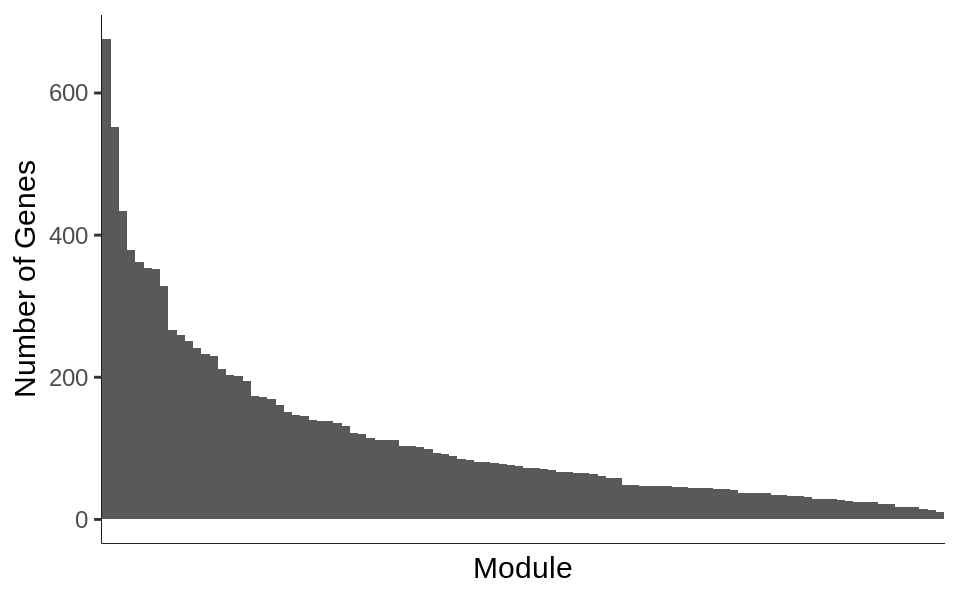

In [44]:
plot.data <- as.data.frame(table(dynamic.mods)) %>%
  dplyr::select(Module=1, Frequency=Freq) %>%
  dplyr::filter(Module != 0)

options(repr.plot.width=8, repr.plot.height=5)

ggplot(plot.data) +
  geom_col(aes(x=Module, y=Frequency), width=1) +
  xlab("Module") + ylab("Number of Genes") +
  ggplot_theme +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())
ggsave(filename="04_Expression/results/gene_coexpression_module_sizes.svg", width=8, height=5)

## Save Gene Co-Expression Modules

I save a the list of genes and their assigned modules, the eigengenes, the variance explained by each eigengene, and the connectivity information for each gene.

The modules are labelled `Module_1,Module_2,...`. `Module_0` contains genes that were not assigned to any co-expression module by WGCNA and are therefore labelled as `Unassigned`.

The eigengene of a given co-expression module is the first principal component of the gene expression for the genes within the module.

The variance explained by each eigengene tells us how well the eigengene captures the overall variation found within the module expression data.

In [45]:
### Module Assignment

gene.list <- colnames(gene.exp)

mod.assignment <- dynamic.mods
mod.labels <- paste0("Module_", mod.assignment)
mod.labels[mod.labels == "Module_0"] <- "Unassigned"

modules <- data.frame(
  Gene=gene.list,
  Module=mod.labels
) %>%
  dplyr::arrange(Module, Gene)

write.csv(modules, "~/gains_team282/nikhil/expression/gene_expression/modules.csv", row.names=F)

### Eigengenes

eigengenes.result <- moduleEigengenes(gene.exp[mod.labels != "Unassigned"], colors=mod.labels[mod.labels != "Unassigned"])
eigengene.order <- order(as.numeric(sapply(strsplit(colnames(eigengenes.result$eigengenes), "_"), function(x) x[2])))

eigengenes <- eigengenes.result$eigengenes
colnames(eigengenes) <- sapply(strsplit(colnames(eigengenes), "_"), function(x) paste0("ME_", x[2]))
eigengenes <- eigengenes[,eigengene.order]

rownames(eigengenes) <- rownames(gene.exp)

write.csv(eigengenes, "~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv")

variance.explained <- data.frame(
  Module=colnames(eigengenes),
  Var.Explained=t(eigengenes.result$varExplained[eigengene.order])[,1]
)

write.csv(variance.explained, "~/gains_team282/nikhil/expression/gene_expression/variance.explained.csv", row.names=F)

### Connectivity

connectivity <- connectivity[modules$Gene,]
connectivity <- cbind(connectivity, modules$Module)
colnames(connectivity)[ncol(connectivity)] <- "Module"

write.csv(connectivity, "~/gains_team282/nikhil/expression/gene_expression/connectivity.csv")